In [1]:
import tensorflow as tf
import os
import numpy as np
import random
import pandas as pd
df = pd.read_pickle('seeds_iterated.pkl')
df = df.drop(df[df[0] == df[0].max()].index[0])
df = df.drop(df[df[0] == df[0].max()].index[0])
SEED = int(df[df[0] == df[0].max()].index[0])
print(SEED)
# SEED = 0
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

2023-09-12 17:12:22.681079: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-12 17:12:22.725410: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 17:12:23.412530: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


119


In [2]:
df[df[0] == df[0].max()]

,0
119,0.078233


In [3]:
import glacierml as gl
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import kstest
from scipy.stats import shapiro 
# from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
# import pandas as pd
from tqdm import tqdm

In [4]:
m = 4
df = gl.coregister_data(str(m))
df = df.drop('RGIId', axis = 1)
# df = df.sample(frac=1).reset_index(drop=True)
df_sampler = df.copy()
df_trainer = df.copy()
rs1 = 471
rs2 = 67

df1test = df_sampler.sample(frac = 0.333333333, random_state = rs1)
df_sampler = df_sampler.drop(df1test.index)

df2test = df_sampler.sample(frac = 0.5,random_state = rs1)
df_sampler = df_sampler.drop(df2test.index)

df3test = df_sampler

df1 = df_trainer.drop(df1test.index)
df2 = df_trainer.drop(df2test.index)
df3 = df_trainer.drop(df3test.index)
df_list = [df1,df2,df3]

In [5]:
pr = 0.075
model = {}
model_history = {}
results = {}
normalizer = {}
y = {}
test_features = {}
test_labels = {}
train_features = {}
train_labels = {}
l1 = {}
l2 = {}
q75 = {}
q25 = {}
iqr = {}
gamma = {}
bias = {}
sig = {}
w = {}
unc = {}
residuals = pd.DataFrame()
callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    patience = 10,
    verbose = 0,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True
)
for j, df in zip(range(1,4,1),df_list):
    m = str(4)
    n = str(j)

    # create a copy of df to draw K test sets to be kept in a vault
    total_inputs = (len(df.columns)) * len(df)
    dp = pr * total_inputs
    tp = dp - (len(df.columns) + (len(df.columns)-1) )
    g = (len(df.columns) + (len(df.columns) - 1))
    l2[n+m] = 4
    l1[n+m] = int((dp - 1 - g - 2*l2[n+m]) / (10 + l2[n+m]))

    arch = str(l1[n+m]) + '-' + str(l2[n+m])
    (
        train_features[n+m], test_features[n+m], 
        train_labels[n+m], test_labels[n+m]
    ) = gl.split_data(df,rs2)
    normalizer = preprocessing.Normalization(axis=-1)
    normalizer.adapt(np.array(train_features[n+m]))

    model[n+m] = gl.build_dnn_model(
        normalizer, learning_rate = 0.01, 
        layer_1 = l1[n+m], layer_2 = l2[n+m],loss = 'mae'
    )

    model_history[n+m] = model[n+m].fit(
        train_features[n+m],
        train_labels[n+m],
        validation_split=0.2,
        callbacks = [callback],
        verbose=0, 
        epochs=500
    )
    total_params = model[n+m].count_params()
    print(f'parameters = {total_params}')


    trained_parameters = model[n+m].count_params() - (
        len(df.columns) + (len(df.columns) - 1)
    )
    print(f'trained parameters = {trained_parameters}')



    cp = l1[n+m]*(9+1) + l2[n+m]*(l1[n+m]+1) + 1*(l2[n+m]+1) + g
    print(f'counted params = {cp}')

    total_inputs = len(df) *( len(df.columns)-1)
    parameter_ratio = np.round(trained_parameters / total_inputs,3)
    print(f'parameter / input ratio = {parameter_ratio}')
    print(l1[n+m],l2[n+m])
    results[n+m] = model[n+m].evaluate(test_features[n+m], test_labels[n+m])
    y[n+m] = model[n+m].predict(test_features[n+m]).flatten()

    full_res = str(j + 10)
    y[full_res] =  (
        (model[n+m].predict(df.drop('Thickness',axis = 1)).flatten() - df['Thickness']) 
    )


    full_pred = str(j + 20)
    y[full_pred] = (model[n+m].predict(df.drop('Thickness',axis = 1)).flatten())

    p_res = str(j + 30)
    y[p_res] = (y[full_pred] - df['Thickness']) / df['Thickness']
    bias[p_res] = np.mean(y[p_res]) * np.mean(y[full_pred])

    q75[p_res] = np.percentile(y[p_res], 75)
    q25[p_res] = np.percentile(y[p_res], 25)

    iqr[p_res] = q75[p_res] - q25[p_res]

    sig[p_res] = (iqr[p_res] / 1.34896) * np.mean(y[full_pred])

    w[n] = abs(bias[p_res]) + sig[p_res]**2
    gamma[p_res] = iqr[p_res] / 1.34896

#     unc[n+m] = gamma[p_res] * y[full_pred]

    ver_res = y[full_pred] - df['Thickness']
    ver_res_mean = np.mean(ver_res)
    ver_res_std =  np.std(ver_res)

    test_res = (y[n+m] - test_labels[n+m]) 

    tq75 = np.percentile(test_res,75)
    tq25 = np.percentile(test_res,25)
    TIQR = tq75 - tq25

    vq75 = np.percentile(ver_res,75)
    vq25 = np.percentile(ver_res,25)
    VIQR = vq75 - vq25

#         test_res_m = pd.DataFrame(pd.Series(m,name = 'M'))
    test_res_m = pd.DataFrame(pd.Series(n,name = 'I'))
    test_res_mean = pd.DataFrame(pd.Series(test_res.mean(), name = 'Test Res'))
    test_res_std = pd.DataFrame(pd.Series(test_res.std(),name = 'Test STD'))



    test_res_mean = test_res_m.join(test_res_mean)
    test_res_mean = test_res_mean.join(test_res_std)
    test_res_mean['TRes Max'] = test_res.max()
    test_res_mean['TRes Min'] = test_res.min()
    test_res_mean['TRes IQR'] = TIQR
    test_res_mean['VRes Mean'] = ver_res_mean    
    test_res_mean['VRes STD'] = ver_res_std
    test_res_mean['VRes Max'] = ver_res.max()
    test_res_mean['VRes Min'] = ver_res.min()
    test_res_mean['VRes IQR'] = VIQR

    residuals = pd.concat([residuals,test_res_mean])
    print('')
res = pd.DataFrame(results,index = ['Loss']).T
res = res.reset_index()

residuals = residuals.reset_index()
residuals = pd.concat([res, residuals], axis = 1, ignore_index = False)
residuals = residuals.drop('index', axis = 1)
residuals = residuals.rename(columns = {'Loss':'MAE'})

cols = list(residuals.columns)
a, b = cols.index('MAE'), cols.index('I')
cols[b], cols[a] = cols[a], cols[b]
residuals = residuals[cols]
print(residuals)
residuals.sort_values('MAE')


2023-09-12 17:12:25.621476: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-09-12 17:12:25.683308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [159,9]
	 [[{{node Placeholder/_10}}]]
2023-09-12 17:12:25.683492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tenso

parameters = 168
trained parameters = 149
counted params = 168
parameter / input ratio = 0.073
10 4
3/3 [==============================] - 0s 1ms/step


2023-09-12 17:12:29.247878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [68,1]
	 [[{{node Placeholder/_11}}]]
2023-09-12 17:12:29.248135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [68,1]
	 [[{{node Placeholder/_11}}]]
2023-09-12 17:12:29.364869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [6

8/8 [==============================] - 0s 720us/step



2023-09-12 17:12:29.488506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [227,9]
	 [[{{node Placeholder/_10}}]]
2023-09-12 17:12:29.488703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [227,9]
	 [[{{node Placeholder/_10}}]]
2023-09-12 17:12:29.557370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shap

parameters = 168
trained parameters = 149
counted params = 168
parameter / input ratio = 0.073
10 4
3/3 [==============================] - 0s 1ms/step


2023-09-12 17:12:31.276384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [68,1]
	 [[{{node Placeholder/_11}}]]
2023-09-12 17:12:31.276602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [68,1]
	 [[{{node Placeholder/_11}}]]
2023-09-12 17:12:31.386949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [6

8/8 [==============================] - 0s 713us/step



2023-09-12 17:12:31.537449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [227,9]
	 [[{{node Placeholder/_10}}]]
2023-09-12 17:12:31.537637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [227,9]
	 [[{{node Placeholder/_10}}]]
2023-09-12 17:12:31.607024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape

parameters = 168
trained parameters = 149
counted params = 168
parameter / input ratio = 0.073
10 4
3/3 [==============================] - 0s 1ms/step


2023-09-12 17:12:34.924298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [68,9]
	 [[{{node Placeholder/_10}}]]
2023-09-12 17:12:34.924524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [68,1]
	 [[{{node Placeholder/_11}}]]
2023-09-12 17:12:35.034963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [

8/8 [==============================] - 0s 722us/step

   I        MAE   Test Res   Test STD   TRes Max    TRes Min   TRes IQR   
0  1  15.064870   0.611644  24.821003  95.321884  -87.206261  15.444803  \
1  2  26.339497 -11.085352  47.586833  72.357910 -302.985979  29.999677   
2  3  22.099497  -1.792542  40.073254  80.553833 -243.151672  25.123959   

   VRes Mean   VRes STD   VRes Max    VRes Min   VRes IQR  
0  -1.826956  21.203931  95.321884  -87.206261  16.202042  
1  -7.708122  35.953731  86.262405 -302.985979  29.704790  
2  -2.021702  28.570478  80.553833 -243.151672  21.019942  


2023-09-12 17:12:35.127034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [228,9]
	 [[{{node Placeholder/_10}}]]
2023-09-12 17:12:35.127226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [228,9]
	 [[{{node Placeholder/_10}}]]
2023-09-12 17:12:35.194022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shap

,I,MAE,Test Res,Test STD,TRes Max,TRes Min,TRes IQR,VRes Mean,VRes STD,VRes Max,VRes Min,VRes IQR
0,1,15.064870,0.611644,24.821003,95.321884,-87.206261,15.444803,-1.826956,21.203931,95.321884,-87.206261,16.202042
2,3,22.099497,-1.792542,40.073254,80.553833,-243.151672,25.123959,-2.021702,28.570478,80.553833,-243.151672,21.019942
1,2,26.339497,-11.085352,47.586833,72.357910,-302.985979,29.999677,-7.708122,35.953731,86.262405,-302.985979,29.704790


In [6]:
w

{'1': 202.7608038046416, '2': 512.4990173177443, '3': 453.6926374075634}

In [7]:
y

{'14': array([ 59.79374 ,  22.822046,  35.08959 ,  87.226265,  74.71874 ,
         74.62788 , 103.18163 ,  76.03351 ,  91.658   ,  60.831146,
         74.61005 ,  64.3825  ,  73.03036 ,  74.650444, 151.32188 ,
         77.16505 ,  55.933685,  68.130775,  69.7962  ,  61.318832,
        159.34462 ,  49.868687,  45.58578 ,  47.51889 ,  44.995968,
         44.58798 ,  60.59702 ,  48.882484,  55.21729 ,  58.840252,
         67.28627 ,  36.62476 ,  35.862404,  32.737133,  31.099785,
         19.942211,  26.008907,  33.213337,  58.0325  ,  58.0325  ,
         24.506628,  23.774256,  36.19888 ,  20.955616,  35.488873,
         50.672127,  35.736073,  51.965958,  42.37502 ,  43.533802,
         37.609283,  48.46445 ,  37.69083 ,  41.42557 ,  43.02469 ,
         41.375668,  42.96876 ,  49.05518 ,  49.06089 ,  51.095646,
         48.12033 ,  41.0383  ,  49.085846,  37.356537,  50.661396,
         33.18939 ,  24.790993,  35.76972 ], dtype=float32),
 '11': 0     -37.682022
 1     -87.206261
 2     

In [8]:
RGI = gl.load_RGI()
df = gl.coregister_data('4')
rfp = RGI[list(df.drop('Thickness', axis = 1))]
est = pd.DataFrame()
for i in range(1,4,1):
    n = str(i)
    estimates = pd.Series(
        model[n+m].predict(rfp.drop('RGIId',axis = 1)).flatten(),name = n
    )
    unc['3' + n] = gamma['3'+n] * estimates
    mod_unc = pd.Series(unc['3' + n], name = n+'unc')
    est = pd.concat([est,estimates], axis  = 1)
    est = pd.concat([est,mod_unc],axis = 1)
rfp = rfp.join(est)

 228/6766 [>.............................] - ETA: 4s

2023-09-12 17:12:36.786868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [216501,9]
	 [[{{node Placeholder/_10}}]]
2023-09-12 17:12:36.787095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [216501,9]
	 [[{{node Placeholder/_10}}]]


 272/6766 [>.............................] - ETA: 3s

2023-09-12 17:12:43.099179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [216501,9]
	 [[{{node Placeholder/_10}}]]
2023-09-12 17:12:43.099491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [216501,9]
	 [[{{node Placeholder/_10}}]]


 272/6766 [>.............................] - ETA: 3s

2023-09-12 17:12:48.138784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [216501,9]
	 [[{{node Placeholder/_10}}]]
2023-09-12 17:12:48.139078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [216501,9]
	 [[{{node Placeholder/_10}}]]


6766/6766 [==============================] - 4s 555us/step


In [9]:
for i in range(1,4,1):
    
    dft = rfp[['Area', str(i), str(i)+'unc']]
    vol = dft['Area'] * (dft[str(i)] / 1e3)
    vol_unc = dft['Area'] * ((dft[str(i) + 'unc'] )/ 1e3)

    sum_vol = sum(vol)
    sum_vol_unc = np.sqrt(sum(vol_unc**2))

    print(sum_vol / 1e3)
    print(sum_vol_unc / 1e3)

126.45021919248528
2.4642010458047183
171.4986685880196
8.243005004182933
155.46672523384711
3.6201813862893095


In [10]:
w1 = w['1']
w2 = w['2']
w3 = w['3']

rfp['avg_thickness'] = (
    rfp['1']/w1 + rfp['2']/w2 + rfp['3']/w3
) / (1/w1 + 1/w2 + 1/w3)
rfp['avg_thickness_unc'] = np.sqrt(
    (rfp['1unc']**2 + rfp['2unc']**2 + rfp['3unc']**2) / 3
)
print(len(rfp))

vol = rfp['Area'] * (rfp['avg_thickness'] / 1e3)
vol_unc = dft['Area'] * (rfp['avg_thickness_unc']/ 1e3)
sum_vol = sum(vol)
sum_vol_unc = np.sqrt(sum(vol_unc**2))
print(sum_vol / 1e3)
print(sum_vol_unc / 1e3)

216501
143.1610395262103
5.3890361525114905


In [11]:
w

{'1': 202.7608038046416, '2': 512.4990173177443, '3': 453.6926374075634}

In [12]:
data = gl.load_notebook_data(coregistration = '4')[['RGIId','FMT']]
data = pd.merge(rfp,data,how = 'inner', on = 'RGIId')
data = data.dropna(subset = 'FMT')
print(len(data))
w1 = w['1']
w2 = w['2']
w3 = w['3']

data['avg_thickness'] = (
    data['1']/w1 + data['2']/w2 + data['3']/w3
) / (1/w1 + 1/w2 + 1/w3)
data['avg_thickness_unc'] = np.sqrt(
    (data['1unc']**2 + data['2unc']**2 + data['3unc']**2) / 3
)


vol = data['Area'] * (data['avg_thickness'] / 1e3)
vol_unc = data['Area'] * (data['avg_thickness_unc']/ 1e3)
sum_vol = sum(vol)
sum_vol_unc = np.sqrt(sum(vol_unc**2))
print(sum_vol / 1e3)
print(sum_vol_unc / 1e3)


215519
128.30650990084428
5.005354277734764


In [13]:
data

,RGIId,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,1,1unc,2,2unc,3,3unc,avg_thickness,avg_thickness_unc,FMT
0,RGI60-01.00001,63.6890,-146.8230,42.0,1936,2385,2725,0.360,346,839,20.398819,5.564555,32.101482,14.420249,22.873869,8.158486,23.511946,10.090734,20.0
1,RGI60-01.00002,63.4040,-146.6680,16.0,1713,2005,2144,0.558,162,1197,27.508408,7.503966,29.158609,13.098287,51.992420,18.544281,33.801380,13.805373,29.0
2,RGI60-01.00003,63.3760,-146.0800,18.0,1609,1868,2182,1.685,175,2106,27.636829,7.538999,28.894131,12.979481,51.220356,18.268906,33.627022,13.651085,32.0
3,RGI60-01.00004,63.3810,-146.1200,19.0,1273,1944,2317,3.681,195,4175,35.295803,9.628275,31.047995,13.947014,61.350040,21.881889,40.703217,15.979569,45.0
4,RGI60-01.00005,63.5510,-147.0570,16.0,1494,1914,2317,2.573,181,2981,33.671726,9.185246,32.821507,14.743690,61.883118,22.072023,40.331890,16.216446,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216496,RGI60-19.02748,-53.9860,-37.7325,29.9,310,-999,510,0.042,315,255,34.034885,9.284312,16.221655,7.286901,26.917429,9.600714,28.483669,8.783907,13.0
216497,RGI60-19.02749,-54.8310,-36.1361,23.6,330,-999,830,0.567,200,1130,46.933071,12.802784,18.440660,8.283696,30.449793,10.860612,36.817120,10.808697,21.0
216498,RGI60-19.02750,-54.1884,-37.3018,16.8,10,-999,1110,4.118,308,4329,58.700531,16.012806,31.908308,14.333473,62.214310,22.190149,53.799973,17.834995,56.0
216499,RGI60-19.02751,-68.8656,-90.4266,0.4,170,-999,270,0.011,122,106,79.017868,21.555134,60.191486,27.038509,89.411644,31.890697,77.496483,27.158310,10.0


In [14]:
data_1 = (data['FMT'] / 1e3) * data['Area']
data_2 = (data['avg_thickness'] / 1e3) * data['Area']
x_1 = np.sort(data_1)
y_1 = 1. * np.arange(len(data_1)) / (len(data_1) - 1)
x_2 = np.sort(data_2)
y_2 = 1. * np.arange(len(data_2)) / (len(data_2) - 1)

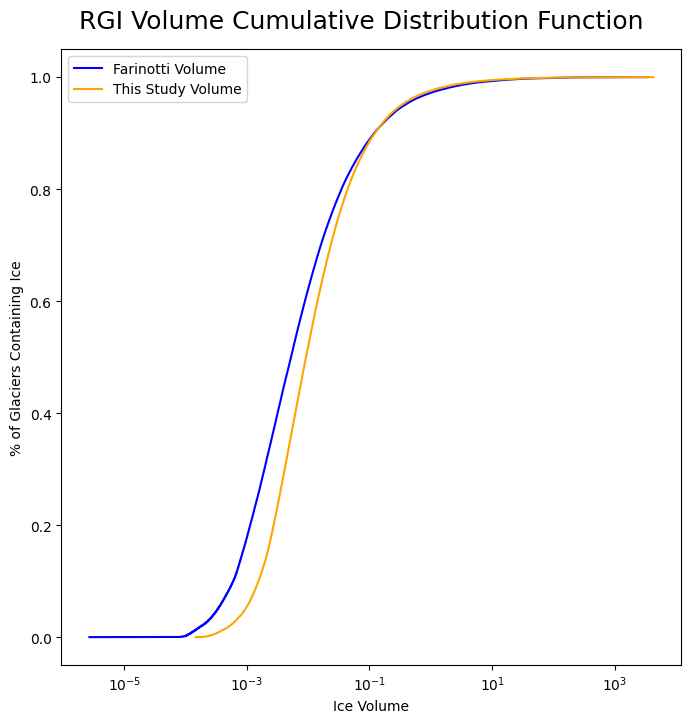

In [15]:
fig, ax = plt.subplots(1,1,figsize=(8, 8))

plt.subplots_adjust(hspace=0.5)

plt.suptitle('RGI Volume Cumulative Distribution Function', fontsize=18, y=0.93)
fig.patch.set_facecolor('w')


plt.subplots_adjust(hspace=0.5)
plt.plot(
    x_1, 
    y_1,
    c = 'blue',
    label = 'Farinotti Volume'
    
)
plt.plot(
    x_2, 
    y_2,
    c = 'orange',
    label = 'This Study Volume'
)
plt.legend()
ax.set_xscale('log')
ax.set_xlabel('Ice Volume')
ax.set_ylabel('% of Glaciers Containing Ice')

k = 1
# for lambd in (1/ 1e3,10/ 1e3,100/ 1e3):
#     plt.plot(x_1, 1 - np.exp(- (x_1/lambd)**k ),'--')
# plt.savefig('figs/cdf/cdf.svg')
plt.show()

In [16]:
from tqdm import tqdm
N1 = len(data_1)
assert len(data_1) == len(data_2)
resample_rate = 0.9
Nsample = int(N1 * resample_rate)
X = []
for i in tqdm(range(1000)):
    sum1 = np.sum(data_1.to_numpy()[np.random.choice(N1, size=Nsample, replace=False)])
    sum2 = np.sum(data_2.to_numpy()[np.random.choice(N1, size=Nsample, replace=False)])

    X.append (sum1-sum2)

100%|██████████| 1000/1000 [00:06<00:00, 155.60it/s]


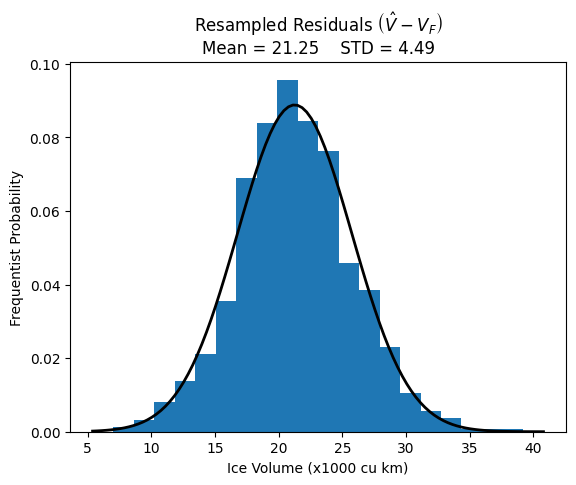

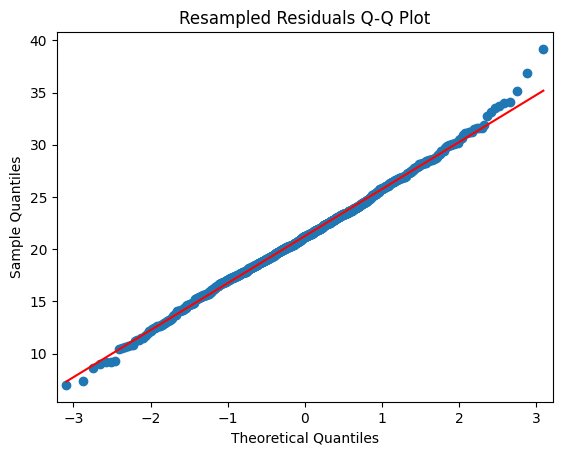

ShapiroResult(statistic=0.9977542757987976, pvalue=0.19434303045272827)
KstestResult(statistic=0.9999999999986422, pvalue=0.0, statistic_location=6.991707748056764, statistic_sign=-1)


In [17]:


t = np.array(X)/resample_rate/1e3
# s = pd.Series(t)
mu, std = norm.fit(t) 
mu = np.round(mu, 2)
std = np.round(std, 2)
plt.hist(t, bins=20, density = True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.ylabel('Frequentist Probability')
plt.xlabel('Ice Volume (x1000 cu km)')
plt.plot(x, p, 'k', linewidth=2)

plt.title(
    f'Resampled Residuals ' + r'$\left(\hat{V} - V_{F}\right)$' +'\n' +
    f'Mean = {mu}    STD = {std}'
)
plt.show()
fig = sm.qqplot(t,line = 'r')

plt.title(f'Resampled Residuals Q-Q Plot')
plt.show()
# print(f'coregistration {m}')

print(shapiro(t))
print(kstest(t, 'norm'))

/home/sa42/miniconda3/envs/new_kernel/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sa42/miniconda3/envs/new_kernel/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


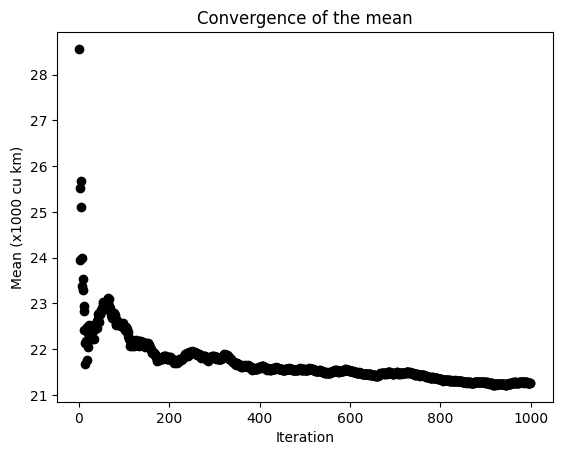

In [18]:
fig,ax=plt.subplots()
for i in range(len(X)):
    ax.plot(i,np.mean(X[0:i])/1e3/resample_rate,'ok')
plt.title('Convergence of the mean')
plt.xlabel('Iteration')
plt.ylabel('Mean (x1000 cu km)')
plt.show()

In [19]:
mu  = np.mean(X)/resample_rate/1e3
sig = np.std(X)/resample_rate/1e3
print(f'Mean of Differences = {mu:.2f}')
print(f'Std of Differences = {sig:.2f}')
from scipy.stats import norm
value = 0 # this corresponds to zero difference
probability=norm.pdf(value,loc = mu, scale=sig)
print(f'Probability of equality of volumes = 10**{np.log10(probability):.2f}')

Mean of Differences = 21.25
Std of Differences = 4.49
Probability of equality of volumes = 10**-5.92


In [20]:
probability

1.1915040357048666e-06

In [21]:
mu1 = np.sum(data_1.to_numpy())
mu2 = np.sum(data_2.to_numpy())
std1 = 41
std2 = 42.19
N = len(data_2.to_numpy())
Z = np.abs(mu1-mu2) / np.sqrt(std1**2/N+std2**2/N)
print(f'log10(Z) = {np.log10(Z)}')

print(f'p  = {norm.sf(abs(Z))}')

log10(Z) = 5.222669723576956
p  = 0.0


In [22]:
# m_F = (data['FMT'] * data['Area']).to_numpy()
# m_E = (data['avg_thickness'] * data['Area']).to_numpy()
# s_E = (data['avg_thickness_unc'] * data['Area']).to_numpy()

# N = len(data_1)

# resample_rate = 0.9
# Nsample = int(N1 * resample_rate)
# X = []
# vector_normal_rand = np.vectorize(norm.rvs)
# for i in tqdm(range(1000)):
    
#     # First, draw from the Bootstrap EDF
#     edasi_sample=vector_normal_rand(m_E,s_E)
# #     edasi_sample = np.zeros_like(m_E)
# #     for i in range(len(edasi_sample)):
# #         edasi_sample[i] = norm.rvs(loc=m_E[i], scale=s_E[i], size=1)
    
#     mc_resample_F = m_F[np.random.choice(N, size=Nsample, replace=False)]
#     mc_resample_E = m_E[np.random.choice(N, size=Nsample, replace=False)]
    
#     sum_F = np.sum(mc_resample_F)
#     sum_E = np.sum(mc_resample_E)

#     X.append (sum_F-sum_E)

# plt.hist(np.array(X)/1e6 / resample_rate)
# plt.show()

# mu  = np.mean(X)/resample_rate/1e6
# sig = np.std(X)/resample_rate/1e6
# print(f'Mean of Differences = {mu:.2f}')
# print(f'Std of Differences = {sig:.2f}')

In [23]:
x = data['Area'] * (data['FMT'] / 1e3)
y = data['Area'] * (data['avg_thickness'] / 1e3)
xy = np.vstack([np.log10(x),np.log10(y)])
# z = gaussian_kde(xy)(xy)

In [24]:
bins_x = np.logspace(np.log10(np.min(x)), np.log10(np.max(x)), 25)
bins_y = np.logspace(np.log10(np.min(y)), np.log10(np.max(y)), 25)

Drawing scatter plot...
Drawing done
Setting scales and labels...


Text(10, 3500, 'B.')

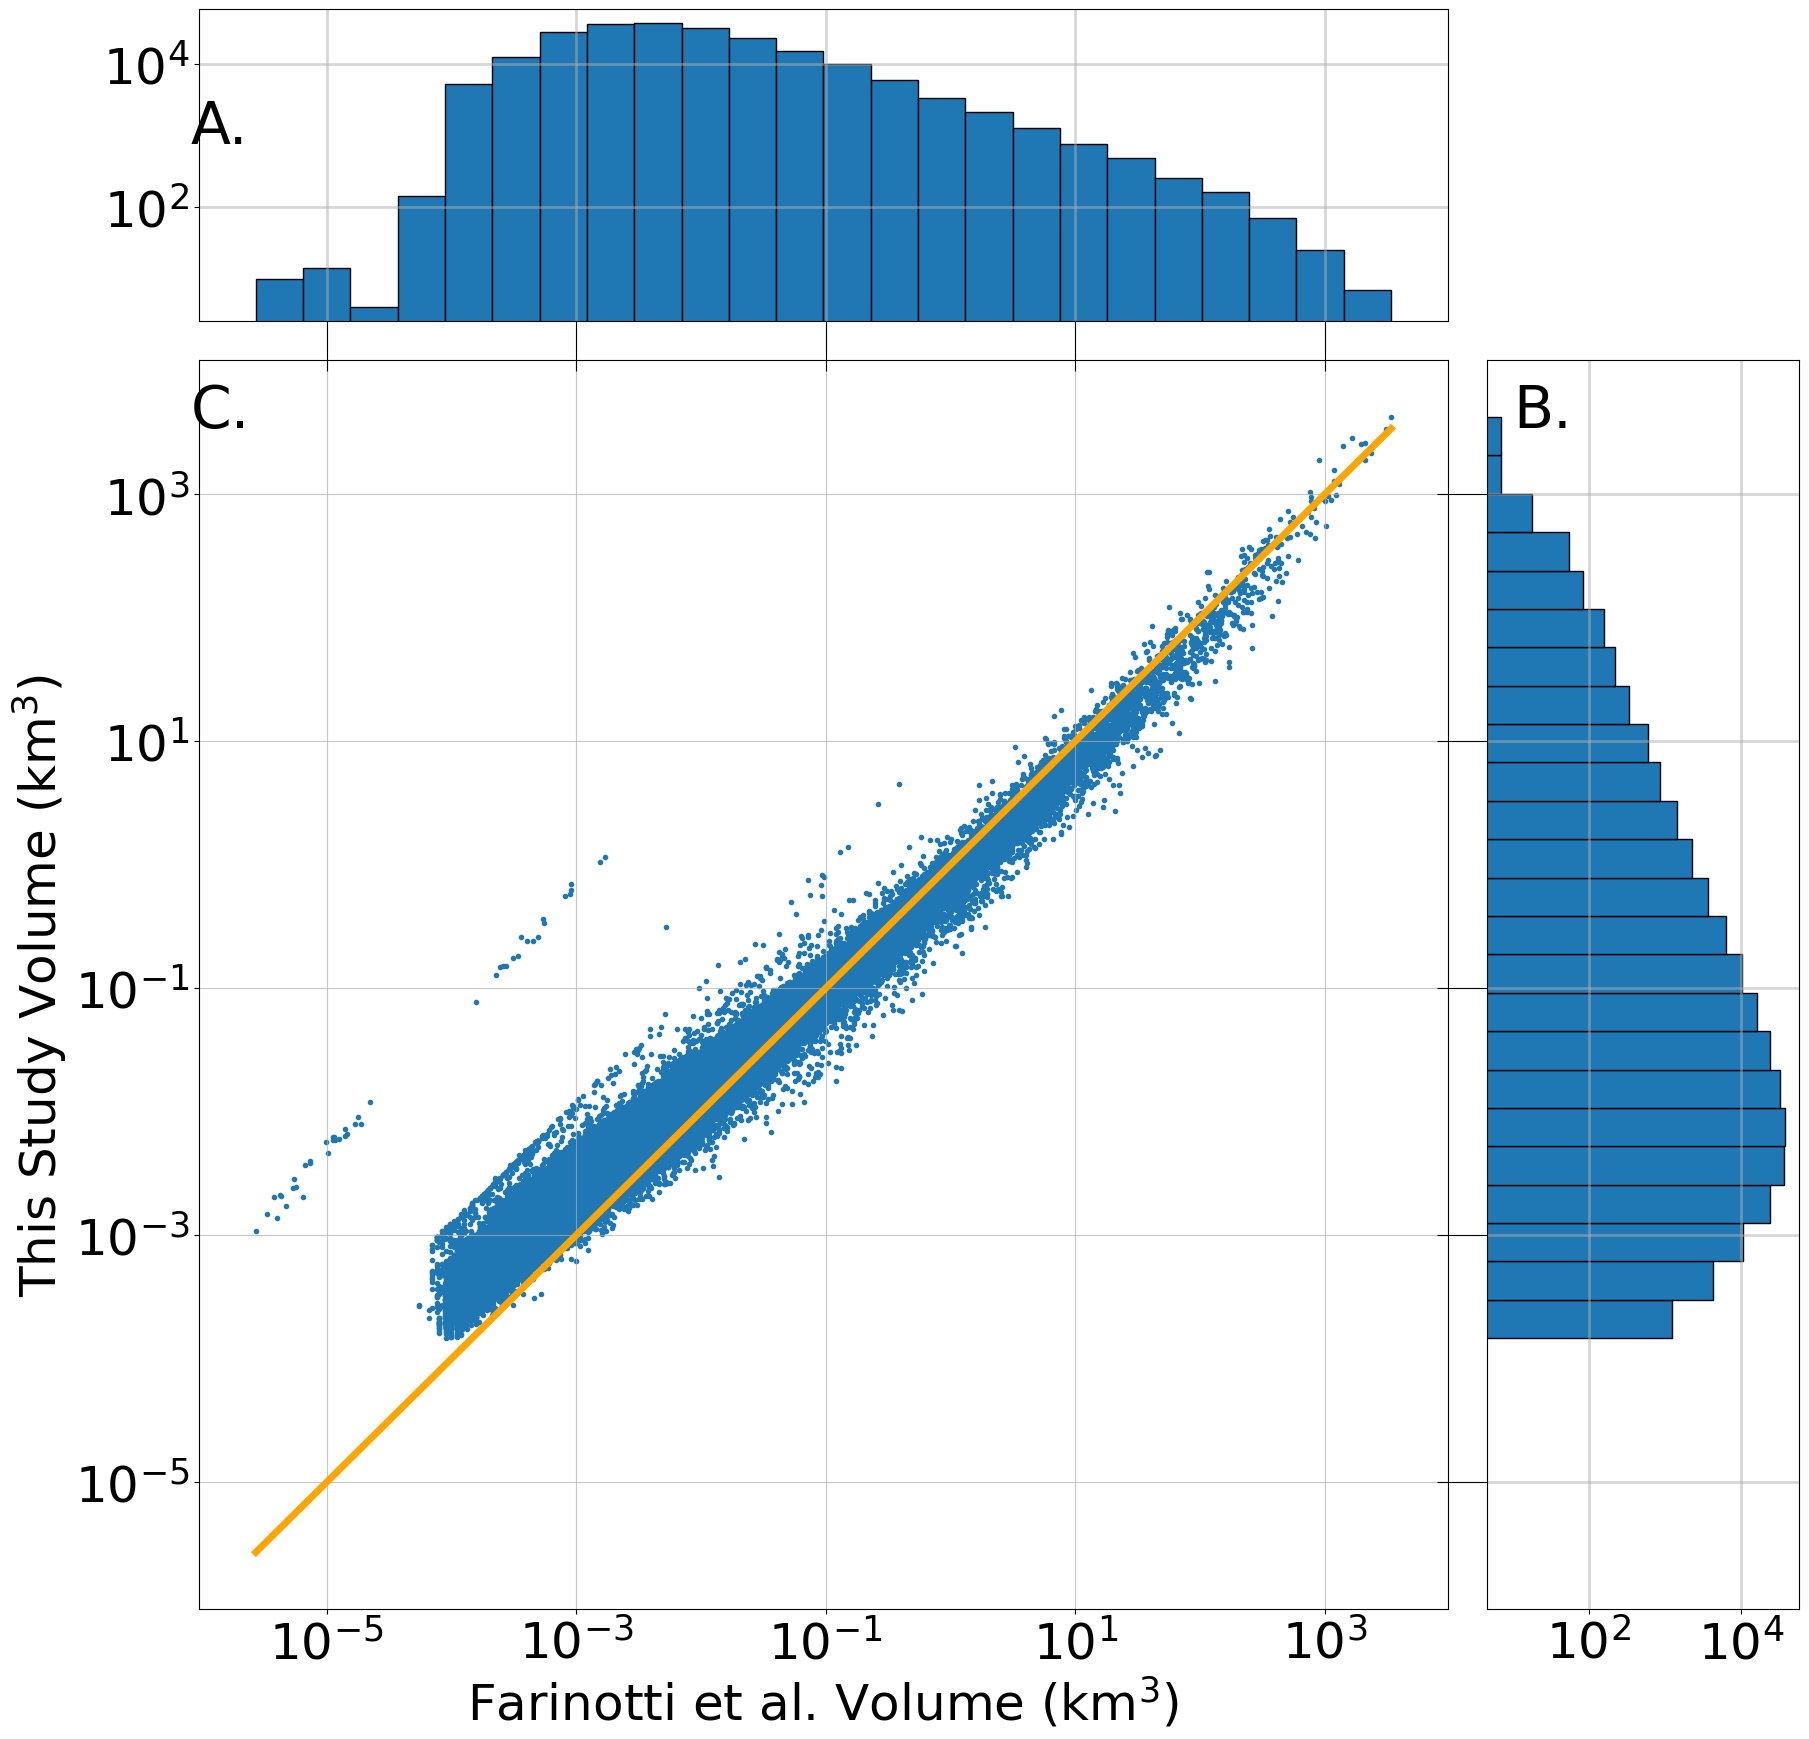

In [25]:
def scatter_hist(x, y, ax, 
                 ax_histx, ax_histy
                ):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False, size = 36)
    ax_histy.tick_params(axis="y", labelleft=False, size = 36)

    # the scatter plot:
    ax.scatter(x, y, 
#                c = (z), 
#                s = 100,
#                cmap = 'viridis',
               marker = '.'
              )
    ax.plot(
        (x.min(),x.max()),
        (x.min(),x.max()),
        '-',
        c = 'orange',
        linewidth = 5

    )
    

    ax_histx.hist(
        (x), 
        bins = bins_x,
        edgecolor = 'black',
        log = True
    )

    ax_histy.hist(
        (y), 
        bins = bins_y, 
        edgecolor = 'black',
        orientation='horizontal',
        log = True
    )
    ax_histx.tick_params(axis="x", labelsize=36)
    ax_histy.tick_params(axis="y", labelsize=36)
    ax_histy.grid(alpha = 0.5,linewidth = 2)
    ax_histx.grid(alpha = 0.5,linewidth = 2)


# ax.set_yticks(major_ticks)
# ax.set_yticks(minor_ticks, minor = True)

fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)


# Create the Axes.

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex = ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey = ax)


ax_histx.tick_params(axis="y", labelsize=36)
ax_histy.tick_params(axis="x",which = 'major', labelsize=36)

# ax.tick_params(axis="both",which = 'major', labelsize=36)

# Specify tick label size
ax.tick_params(axis = 'both', which = 'major', labelsize = 36)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)
# Suppress minor tick labels

major_ticks = np.linspace(-5,3,5)
minor_ticks = np.linspace(-4,4,5)


ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor = True)

ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor = True)

# Set both ticks to be outside
ax.tick_params(which = 'both', direction = 'out')

# Specify different settings for major and minor grids
ax.grid(which = 'minor', alpha = 0.3)
ax.grid(which = 'major', alpha = 0.7)


# ax.tick_params(axis="both",which = 'minor', labelsize=28)

# ax.grid(which = 'major',alpha = 0.5,linewidth = 2)


# ax.set_xticks(minor_ticks, labels=minor_ticks, minor=True)

print('Drawing scatter plot...')
scatter_hist(
    x, 
    y,
    ax, 
    ax_histx,
    ax_histy,
)
print('Drawing done')
print('Setting scales and labels...')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('This Study Volume (km$^3$)', fontsize = 36)
ax.set_xlabel('Farinotti et al. Volume (km$^3$)', fontsize = 36)
# ax.minorticks_on()
# ax.grid(which = 'minor',alpha = 0.5,linewidth = 1,linestyle = '--')
plt.text(1e-17 + 3e-17, 700000, 'A.',fontsize = 42)
plt.text(1e-17 + 3e-17, 3500, 'C.',fontsize = 42)
plt.text(10, 3500, 'B.',fontsize = 42)